In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, LeaveOneOut

In [74]:
# Load the dataset
pre17_path = os.path.join(os.getcwd(), '..', 'robject', 'joint_pre17.csv')
pre17 = pd.read_csv(pre17_path, delimiter = ',')
year17_path = os.path.join(os.getcwd(), '..', 'robject', 'joint_17.csv')
year17 = pd.read_csv(year17_path, delimiter = ',')

In [3]:
# 5-fold cv
kf = KFold(n_splits=5, shuffle=True, random_state=24082018)

In [4]:
def init_classifiers(X):
    classifiers = [
        LogisticRegression(solver='lbfgs'), 
        MultinomialNB(), 
        KNeighborsClassifier(n_neighbors=2), 
    #     MLPClassifier(),
        MLPClassifier(hidden_layer_sizes=np.repeat(X.shape[0]/2, 2).astype(int)), 
        DecisionTreeClassifier(max_depth=10), 
        RandomForestClassifier(n_estimators=100), 
        LinearSVC(C=0.025), 
        LinearDiscriminantAnalysis(), 
        QuadraticDiscriminantAnalysis()
    ]
    return classifiers

In [5]:
names = [
    'Logistic Regression', 
    'Multinomial NB', 
    'Nearest Neighbours', 
    'Multi-Layer Perceptron', 
    'Decision Tree', 
    'Random Forest', 
    'Linear SVM', 
    'Linear DA', 
    'Quadratic DA'
]

In [6]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
course_abbr = {
    'ILA': 'Introduction to Linear Algebra', 
    'CAP': 'Calculus and its Applications', 
    'PPS': 'Proofs and Problem Solving', 
    'Y1Fs': 'Three Year 1 Courses'
}

In [67]:
names_short = [
    'LR', 
    'MNB', 
    'KNN', 
    'MLP', 
    'DT', 
    'RF', 
    'SVM', 
    'LDA', 
    'QDA'
]

In [88]:
def mdt_vs_course(course, mdt_gen):
    if mdt_gen == 2:
        data = pre17
        yr_str = '(2013-2016)'
        file_name = '../fig/ML_' + course + '_bin_pre17.pdf'
    elif mdt_gen == 3:
        data = year17
        yr_str = '(2017)'
        file_name = '../fig/ML_' + course + '_bin_17.pdf'
    else:
        raise Exception('Invalid input. ')
        
    if course == 'Y1Fs':
        classes = ['At-Risk', 'Not-At-Risk']
    else:
        classes = ['Fail', 'Pass']
    
    df = pd.concat([data.iloc[:,1:21], data[[course + '.bin', 'F1', 'School', 'Gender', 'Region']]], axis = 1)
    df = df.dropna()
    
    # Convert categorical variable to ordinal
    le_dict = dict()
    df_num = df.copy(deep = True)
    for column in df_num[['Gender']]:
        le = LabelEncoder().fit(df[column])
        df_num[column] = le.transform(df[column])
        le_dict[column] = le
        
    X = df_num.drop(columns = [course + '.bin', 'F1'])
    y = df_num[course + '.bin']
    
    cmlist = []
    plt.subplots(3, 3, figsize = (10, 10))
    for i, (name, clf) in enumerate(zip(names, init_classifiers(X))):
        clf_predict = cross_val_predict(clf, X, y, cv=kf.split(X))
        cm = confusion_matrix(y, clf_predict)
        cmlist.append(cm)
        cm_norm = cm / cm.sum(axis = 1)[:, np.newaxis]
        plt.subplot(3, 3, i + 1)
        plot_confusion_matrix(cm_norm, classes, title = name)
    plt.suptitle(course_abbr[course] + ' ' + yr_str, fontsize = 16)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.88)
    plt.savefig(file_name)
    
    cm_df = pd.DataFrame(np.concatenate(cmlist).reshape(9,4)).T
    cm_df.columns = names_short
    cm_df.index = ['TP','FN','FP','TN']
    ACC = np.array([])
    for cm in cmlist:
        ACC = np.append(ACC, (cm/cm.sum()).diagonal().sum())
    (ACC*100).astype(int)
    cm_df.loc['ACC'] = (ACC*100).astype(int)
    print(cm_df.to_latex())

In [96]:
def both_vs_course(course):
    data = year17
    yr_str = '(2017)'
    file_name = '../fig/ML_' + course + '_bin_Qual_17.pdf'
        
    if course == 'Y1Fs':
        classes = ['At-Risk', 'Not-At-Risk']
    else:
        classes = ['Fail', 'Pass']
    
    df = pd.concat([data.iloc[:,1:21], data[[course + '.bin', 'F1', 'School', 'Gender', 'Region', 'Category']]], axis = 1)
    df = df.dropna()
    
    # Convert categorical variable to ordinal
    le_dict = dict()
    df_num = df.copy(deep = True)
    for column in df_num[['Gender', 'Category']]:
        le = LabelEncoder().fit(df[column])
        df_num[column] = le.transform(df[column])
        le_dict[column] = le
        
    X = df_num.drop(columns = [course + '.bin', 'F1'])
    y = df_num[course + '.bin']
    
    cmlist = []
    plt.subplots(3, 3, figsize = (10, 10))
    for i, (name, clf) in enumerate(zip(names, init_classifiers(X))):
        clf_predict = cross_val_predict(clf, X, y, cv=kf.split(X))
        cm = confusion_matrix(y, clf_predict)
        cmlist.append(cm)
        cm_norm = cm / cm.sum(axis = 1)[:, np.newaxis]
        plt.subplot(3, 3, i + 1)
        plot_confusion_matrix(cm_norm, classes, title = name)
    plt.suptitle(course_abbr[course] + ' ' + yr_str, fontsize = 16)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.88)
    plt.savefig(file_name)
    
    cm_df = pd.DataFrame(np.concatenate(cmlist).reshape(9,4)).T
    cm_df.columns = names_short
    cm_df.index = ['TP','FN','FP','TN']
    ACC = np.array([])
    for cm in cmlist:
        ACC = np.append(ACC, (cm/cm.sum()).diagonal().sum())
    (ACC*100).astype(int)
    cm_df.loc['ACC'] = (ACC*100).astype(int)
    print(cm_df.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   65 &  128 &  119 &   73 &   76 &   56 &   52 &   79 &  113 \\
FN  &  181 &  118 &  127 &  173 &  170 &  190 &  194 &  167 &  133 \\
FP  &   46 &  207 &  242 &  114 &  173 &   35 &   33 &   59 &  166 \\
TN  &  958 &  797 &  762 &  890 &  831 &  969 &  971 &  945 &  838 \\
ACC &   81 &   74 &   70 &   77 &   72 &   82 &   81 &   81 &   76 \\
\bottomrule
\end{tabular}



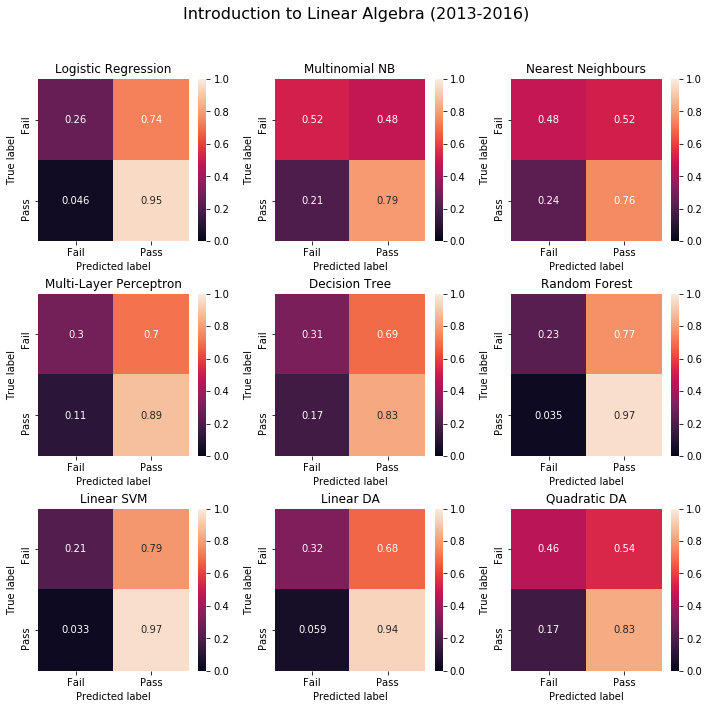

In [70]:
mdt_vs_course('ILA', 2)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   39 &   99 &  100 &   69 &   74 &   32 &   25 &   52 &   82 \\
FN  &  167 &  107 &  106 &  137 &  132 &  174 &  181 &  154 &  124 \\
FP  &   31 &  167 &  228 &   94 &  154 &   24 &   20 &   40 &  127 \\
TN  &  936 &  800 &  739 &  873 &  813 &  943 &  947 &  927 &  840 \\
ACC &   83 &   76 &   71 &   80 &   75 &   83 &   82 &   83 &   78 \\
\bottomrule
\end{tabular}



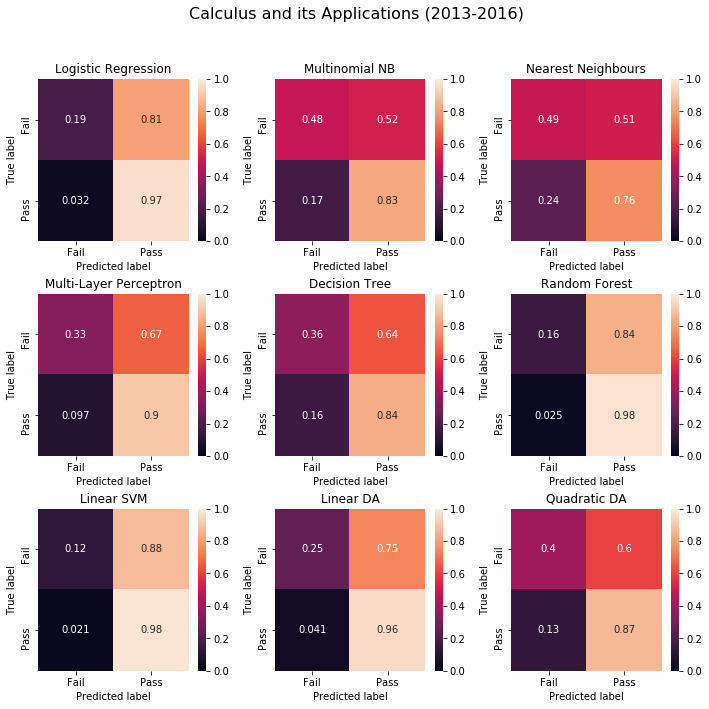

In [85]:
mdt_vs_course('CAP', 2)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   30 &   76 &   69 &   44 &   51 &   20 &   26 &   43 &   50 \\
FN  &  125 &   79 &   86 &  111 &  104 &  135 &  129 &  112 &  105 \\
FP  &   41 &  101 &  152 &   81 &   97 &   32 &   30 &   51 &   88 \\
TN  &  546 &  486 &  435 &  506 &  490 &  555 &  557 &  536 &  499 \\
ACC &   77 &   75 &   67 &   74 &   72 &   77 &   78 &   78 &   73 \\
\bottomrule
\end{tabular}



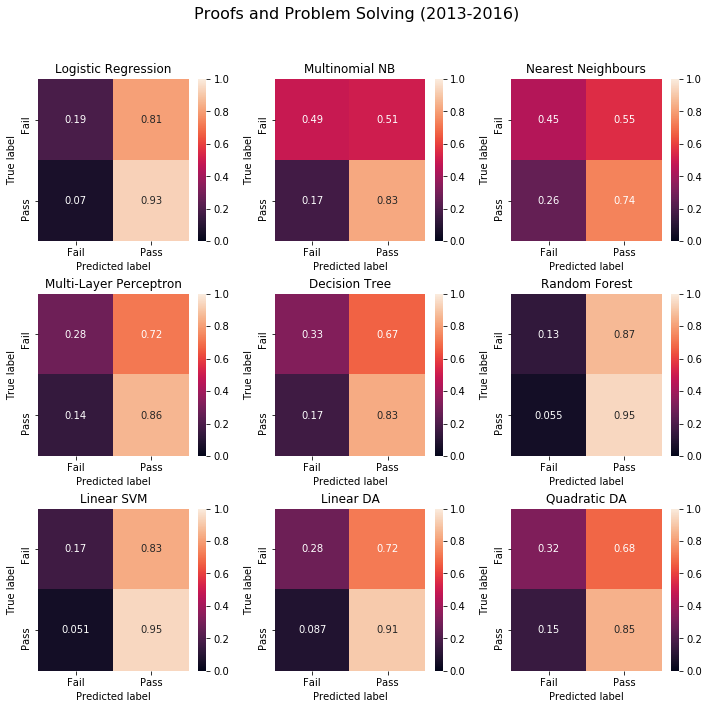

In [86]:
mdt_vs_course('PPS', 2)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   22 &   57 &   42 &   15 &   30 &   12 &   11 &   29 &   40 \\
FN  &   91 &   56 &   71 &   98 &   83 &  101 &  102 &   84 &   73 \\
FP  &   20 &  100 &  141 &   50 &   92 &   13 &   13 &   30 &   66 \\
TN  &  591 &  511 &  470 &  561 &  519 &  598 &  598 &  581 &  545 \\
ACC &   84 &   78 &   70 &   79 &   75 &   84 &   84 &   84 &   80 \\
\bottomrule
\end{tabular}



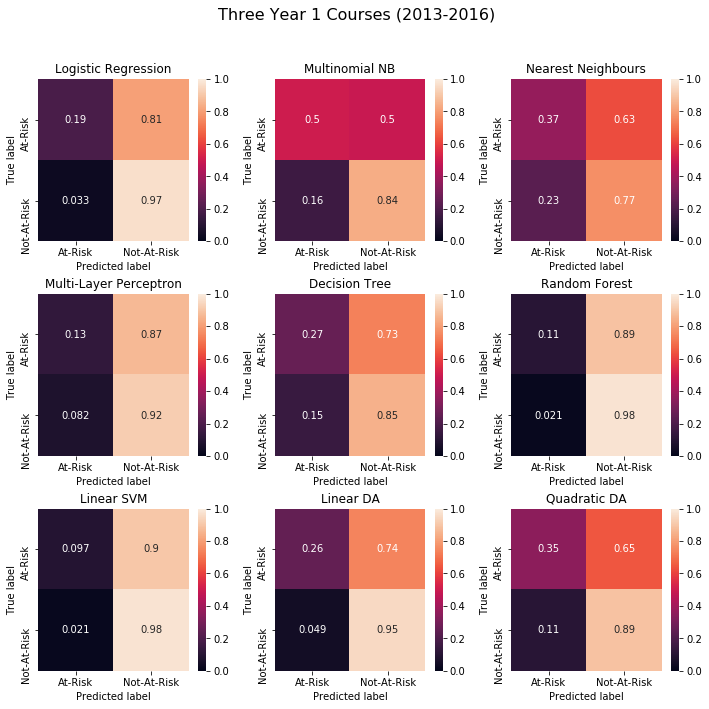

In [89]:
mdt_vs_course('Y1Fs', 2)

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear"

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &    5 &   11 &   14 &    6 &   10 &    3 &    3 &   10 &    9 \\
FN  &   29 &   23 &   20 &   28 &   24 &   31 &   31 &   24 &   25 \\
FP  &    7 &   40 &   43 &   10 &   26 &    4 &    6 &   12 &   41 \\
TN  &  310 &  277 &  274 &  307 &  291 &  313 &  311 &  305 &  276 \\
ACC &   89 &   82 &   82 &   89 &   85 &   90 &   89 &   89 &   81 \\
\bottomrule
\end{tabular}



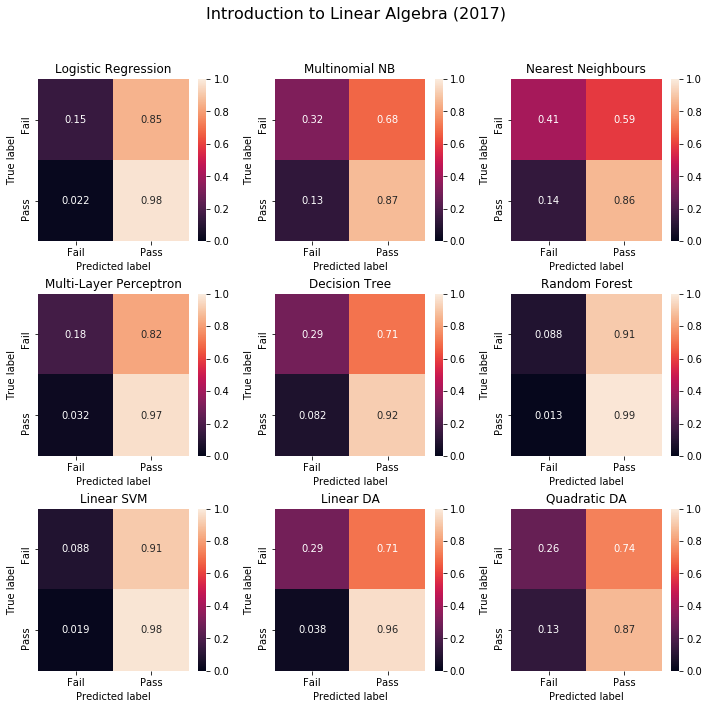

In [90]:
mdt_vs_course('ILA', 3)

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   15 &   30 &   30 &   20 &   22 &   14 &   14 &   21 &   23 \\
FN  &   49 &   34 &   34 &   44 &   42 &   50 &   50 &   43 &   41 \\
FP  &   20 &   42 &   61 &   30 &   42 &   10 &   17 &   23 &   25 \\
TN  &  237 &  215 &  196 &  227 &  215 &  247 &  240 &  234 &  232 \\
ACC &   78 &   76 &   70 &   76 &   73 &   81 &   79 &   79 &   79 \\
\bottomrule
\end{tabular}



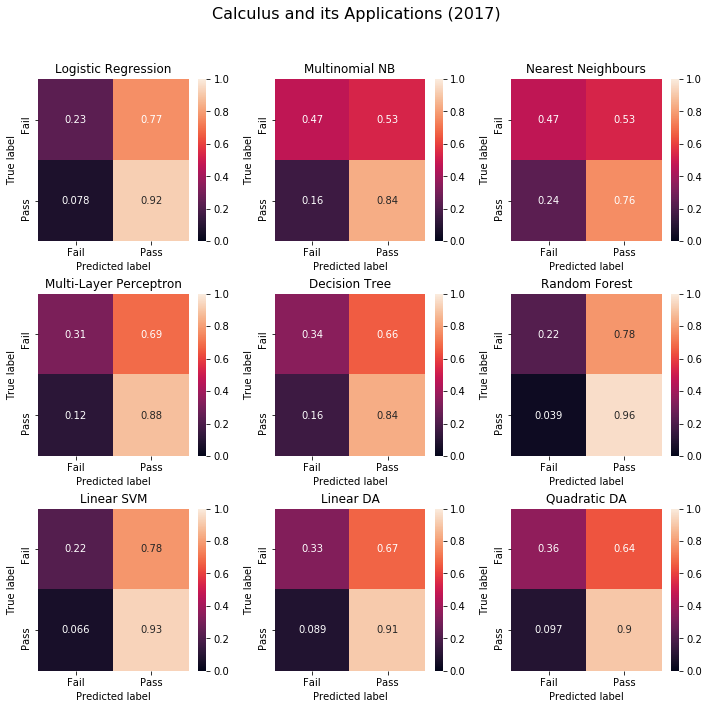

In [91]:
mdt_vs_course('CAP', 3)

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   15 &   21 &   28 &   11 &   21 &   18 &   16 &   15 &   11 \\
FN  &   39 &   33 &   26 &   43 &   33 &   36 &   38 &   39 &   43 \\
FP  &   18 &   25 &   51 &   20 &   38 &   15 &   16 &   17 &   16 \\
TN  &  124 &  117 &   91 &  122 &  104 &  127 &  126 &  125 &  126 \\
ACC &   70 &   70 &   60 &   67 &   63 &   73 &   72 &   71 &   69 \\
\bottomrule
\end{tabular}



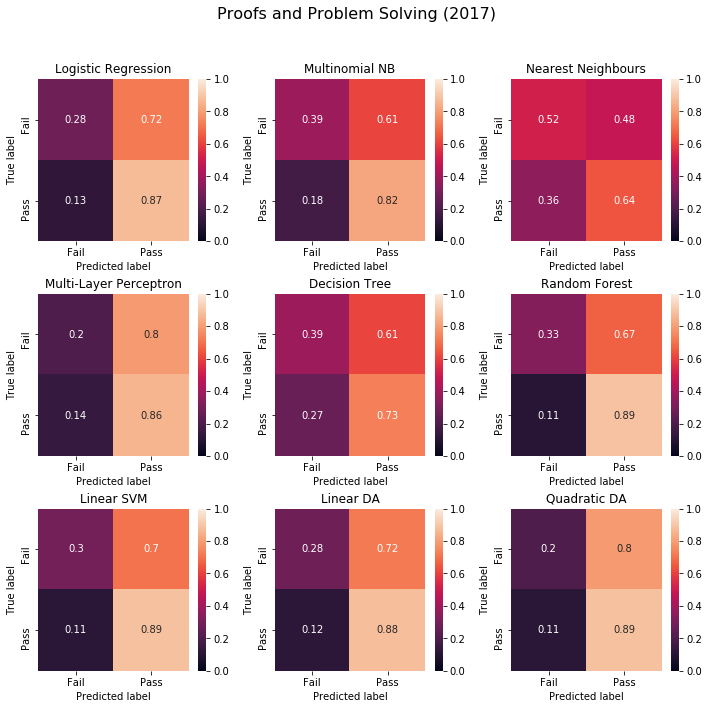

In [92]:
mdt_vs_course('PPS', 3)

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &    4 &    6 &    9 &    2 &    6 &    2 &    3 &    8 &    0 \\
FN  &   20 &   18 &   15 &   22 &   18 &   22 &   21 &   16 &   24 \\
FP  &   13 &   15 &   32 &   10 &   27 &    2 &   10 &   14 &    0 \\
TN  &  146 &  144 &  127 &  149 &  132 &  157 &  149 &  145 &  159 \\
ACC &   81 &   81 &   74 &   82 &   75 &   86 &   83 &   83 &   86 \\
\bottomrule
\end{tabular}



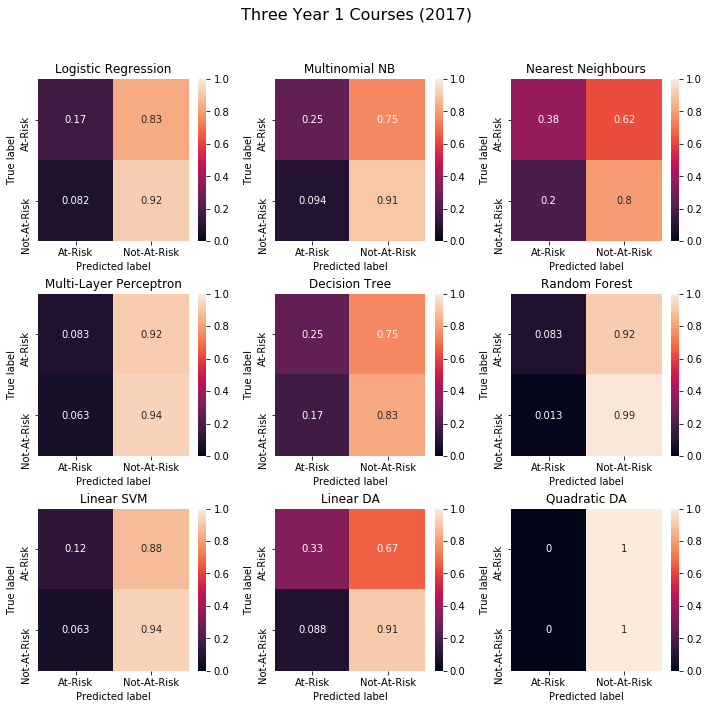

In [93]:
mdt_vs_course('Y1Fs', 3)

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_ana

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &    6 &   12 &   14 &    3 &    8 &    3 &    3 &   10 &    8 \\
FN  &   28 &   22 &   20 &   31 &   26 &   31 &   31 &   24 &   26 \\
FP  &   11 &   38 &   44 &   12 &   33 &    3 &    8 &   15 &   34 \\
TN  &  306 &  279 &  273 &  305 &  284 &  314 &  309 &  302 &  283 \\
ACC &   88 &   82 &   81 &   87 &   83 &   90 &   88 &   88 &   82 \\
\bottomrule
\end{tabular}



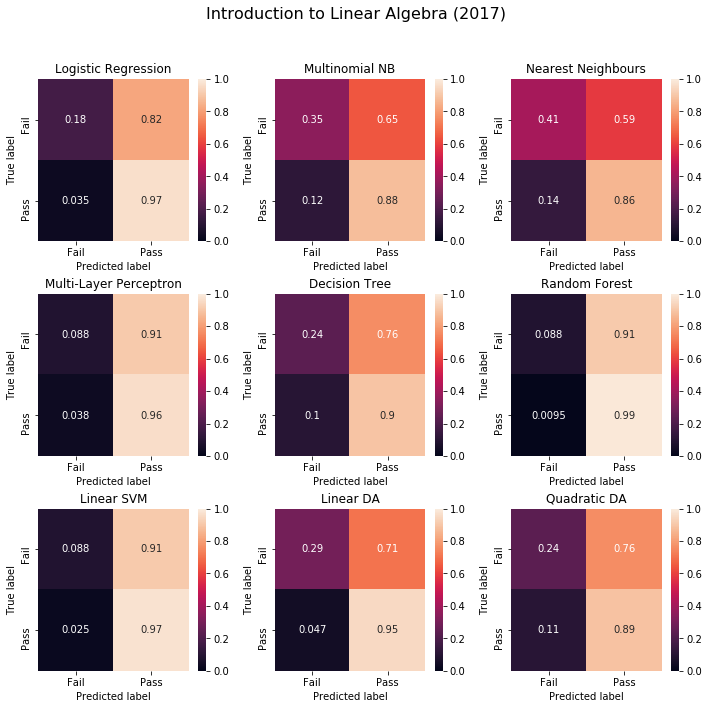

In [95]:
both_vs_course('ILA')

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   19 &   30 &   32 &   19 &   21 &   18 &   17 &   23 &   23 \\
FN  &   45 &   34 &   32 &   45 &   43 &   46 &   47 &   41 &   41 \\
FP  &   23 &   34 &   59 &   27 &   46 &   10 &   19 &   23 &   21 \\
TN  &  234 &  223 &  198 &  230 &  211 &  247 &  238 &  234 &  236 \\
ACC &   78 &   78 &   71 &   77 &   72 &   82 &   79 &   80 &   80 \\
\bottomrule
\end{tabular}



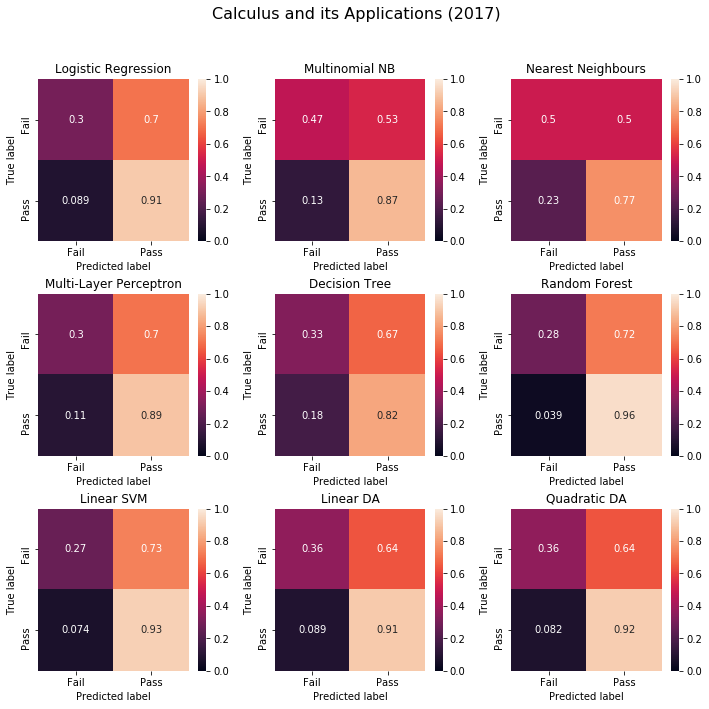

In [97]:
both_vs_course('CAP')

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &   18 &   22 &   27 &   22 &   20 &   11 &   16 &   16 &   24 \\
FN  &   36 &   32 &   27 &   32 &   34 &   43 &   38 &   38 &   30 \\
FP  &   19 &   24 &   49 &   28 &   34 &   10 &   15 &   19 &   26 \\
TN  &  123 &  118 &   93 &  114 &  108 &  132 &  127 &  123 &  116 \\
ACC &   71 &   71 &   61 &   69 &   65 &   72 &   72 &   70 &   71 \\
\bottomrule
\end{tabular}



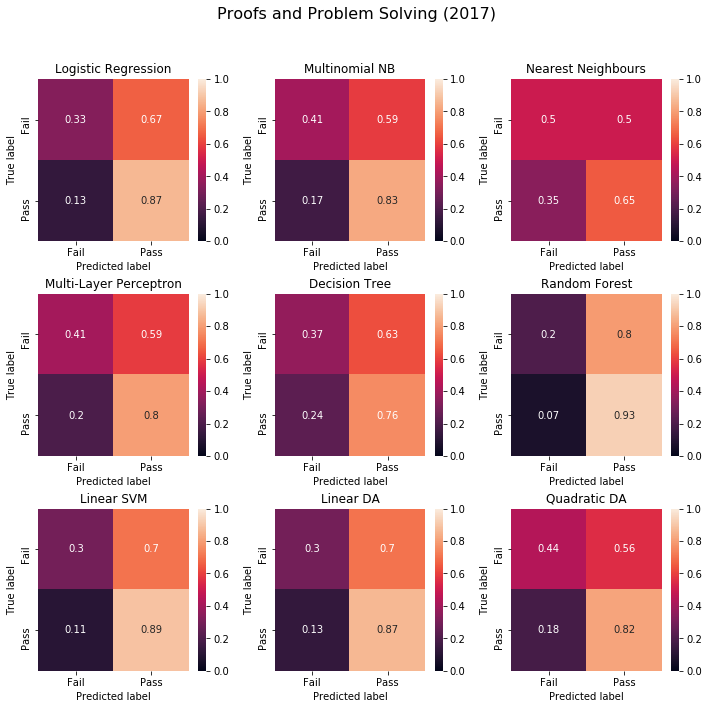

In [98]:
both_vs_course('PPS')

/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/s1680642/miniconda3/envs/iaml/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/s1680642/miniconda3/envs/iaml/lib/python3

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   LR &  MNB &  KNN &  MLP &   DT &   RF &  SVM &  LDA &  QDA \\
\midrule
TP  &    8 &    8 &    9 &    5 &    9 &    4 &    6 &    6 &    0 \\
FN  &   16 &   16 &   15 &   19 &   15 &   20 &   18 &   18 &   24 \\
FP  &   14 &   17 &   32 &    5 &   23 &    3 &    9 &   12 &    0 \\
TN  &  145 &  142 &  127 &  154 &  136 &  156 &  150 &  147 &  159 \\
ACC &   83 &   81 &   74 &   86 &   79 &   87 &   85 &   83 &   86 \\
\bottomrule
\end{tabular}



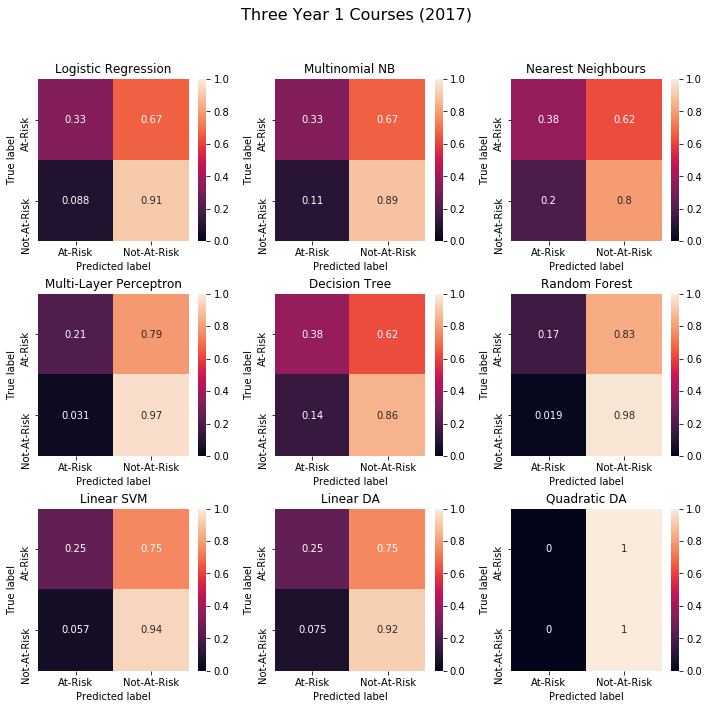

In [99]:
both_vs_course('Y1Fs')